# 나는 고양이상일까, 강아지상일까?

안녕하세요! 이번 시간에는 나의 얼굴이 고양이상에 가까운지, 강아지상에 가까운지 확인해보는 시간을 가져봅시다. :)

실습을 시작하기에 앞서, 이번 프로젝트에서는 파이썬 **Pillow**패키지가 필요합니다. 아래의 커맨드로 install 해주세요!

In [1]:
!pip install pillow

## 1. Dataset 준비하기

가장 먼저, 고양이상인지 강아지상인지 학습알 이미지 데이터가 필요하겠죠?

텐서플로우에서 제공하는 데이터셋을 사용해봅시다.

혹시 설치가 되어있지 않다면 터미널을 열어 `tensorflow_datasets` 패키지를 설치해주세요

```bash
$pip install tensorflow_datasets
```

만약 아나콘다를 이용하는 환경이라면, 아래의 명령어를 입력해주시길 바랍니다.

```bash
$conda install -c anaconda tensorflow-datasets
```

In [1]:
import tensorflow_datasets as tfds

tfds.__version__

'1.2.0'

`tensorflow_datasets`는 텐서플로우가 제공하는 데이터셋입니다.

이번 시간에 필요한 강아지와 고양이 이미지 뿐만아니라 음성 데이터셋, 이미지 데이터셋, 텍스트 데이터셋 등 많은 종류의 데이터셋을 제공하고 있습니다.

자세한 내용은 텐서플로우 공식 홈페이지를 참고하세요.

[텐서플로우 공식 홈페이지 - tensorflow datasets](https://www.tensorflow.org/datasets/catalog/overview)


그럼 이제 `tensorflow_datasets` 라이브러리에서 고양이와 강아지 데이터인 `cats_vs_dogs` 데이터를 사용해봅시다.

In [2]:
(raw_train, raw_validation, raw_test), metadata = tfds.load(
    'cats_vs_dogs',
    split=[
      tfds.Split.TRAIN.subsplit(tfds.percent[:80]),
      tfds.Split.TRAIN.subsplit(tfds.percent[80:90]),
      tfds.Split.TRAIN.subsplit(tfds.percent[90:])
    ],
    with_info=True,
    as_supervised=True,
)

데이터를 불러오면서 동시에 데이터를 나누어주었어요. 전체 train 데이터셋을 80%는 training data, 10%는 validation data, 나머지 10%는 test data로 사용할 것입니다.

그러면 각각의 데이터를 확인해봅시다.

In [3]:
print(raw_train)
print(raw_validation)
print(raw_test)

<_OptionsDataset shapes: ((None, None, 3), ()), types: (tf.uint8, tf.int64)>
<_OptionsDataset shapes: ((None, None, 3), ()), types: (tf.uint8, tf.int64)>
<_OptionsDataset shapes: ((None, None, 3), ()), types: (tf.uint8, tf.int64)>


모든 데이터셋은 `(image, label)`의 형태를 가집니다. `(None, None, 3), ())`가 이를 나타내고 있어요.

여기에서 앞에 있는 `(None, None, 3)`은 image의 **shape**를, 뒤의 `()`는 정답 카테고리인 label의 shape를 의미합니다.


이미지는 `(height, width, channel)`로 이루어진 3차원의 데이터이기 때문에 `(None, None, 3)`과 같이 나타났습니다. 이때 height과 width는 모든 이미지의 크기가 전부 다르기 때문에 None으로 나타났어요!

그럼 3은 무엇일까요? 바로 이미지의 색을 표현하는 채널의 수를 의미합니다. 컬러 이미지의 경우, RGB 세가지 색의 조합으로 나타내어 3이 됩니다. 반대로 흑백 이미지라면 1이 되겠죠?

label의 경우에, 이 cats_vs_dogs 데이터에서는 강아지인지 고양이인지만 구분하기 때문에 단순한 1차원의 숫자로 표현이 될겁니다. 그래서 차원이 따로 나타나지 않았어요!


---

그럼 준비한 데이터를 직접 확인해봅시다. `matplotlib`를 가져와봅시다.

In [4]:
import matplotlib.pyplot as plt
%matplotlib inline
%config inLineBackend.figure_format = 'retina'

`raw_train`안에 있는 데이터를 확인해보기위해 `tf.data.Dataset`에서 제공하는 `take`라는 함수를 사용해봅시다.

이 함수는 인수로 받은 만큼의 개수만큼 데이터를 추출하여 새로운 데이터셋 인스턴스를 생성하여 리턴하는 함수입니다.


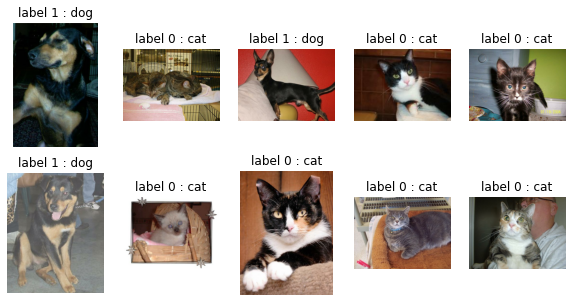

In [5]:
plt.figure(figsize = (10, 5))

get_label_name = metadata.features['label'].int2str

for idx, (image, label) in enumerate(raw_train.take(10)):
    plt.subplot(2, 5, idx+1)
    plt.imshow(image)
    plt.title(f'label {label} : {get_label_name(label)}')
    plt.axis('off')

갹 귀여운 고양이와 강아지 이미지가 가져와졌어요~

label 1은 강아지로, label 0은 고양이로 설정되어있네요. 그리고 이미지 사이즈가 전부 제각각이에요.

모델을 학습시킬 때에는 이미지 사이즈를 통일시켜주는 작업을 해야할 것 같습니다.

아래 함수를 통해 이미지를 같은 포맷으로 통일시켜보아요. 동시에 각 픽셀값의 scale을 재설정해봅시다.

In [6]:
IMG_SIZE = 160 # 이미지 사이즈를 160x160으로 설정해줍시다.

def format_example(image, label):
    image = tf.cast(image, tf.float32)
    image = (image/127.5) -1 # 각 픽셀의 값을 -1과 1사이의 값이 오도록 만들어줍니다.
    image = tf.image.resize(image, (IMG_SIZE, IMG_SIZE)) # 사이즈를 재설정합니다.
    return image, label

이 함수를 이제 저희의 train, validation, test 데이터셋에 적용해볼까요?

In [7]:
import tensorflow as tf

train = raw_train.map(format_example)
validation = raw_validation.map(format_example)
test = raw_test.map(format_example)

잘 변경이 되었을까요? 다시 이미지로 확인해봅시다. 

matplotlib로 이미지를 시각화 할 경우에는 모든 픽셀값이 양수여야하므로, -1~1 사이의 픽셀값에서 1을 더한 후 2로 나누어서 0과 1사이의 값이 나올 수 있도록 변환하봅시다.

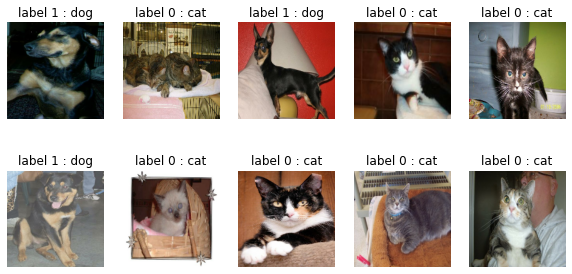

In [8]:
plt.figure(figsize = (10, 5))

get_label_name = metadata.features['label'].int2str

for idx, (image, label) in enumerate(train.take(10)):
    plt.subplot(2, 5, idx+1)
    image = (image+1)/2
    plt.imshow(image)
    plt.title(f'label {label} : {get_label_name(label)}')
    plt.axis('off')

제대로 변경이된 것 같죠? :)


## 모델을 만들어보자

### 텐서플로우를 활용해 모델 구조 설계하기

이미지 준비가 끝났으니 이 이미지들로 학습시킬 모델을 만들어봅시다.

먼저 모델 생성에 필요한 함수들을 가져와봅시다.

In [9]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, MaxPooling2D

- `model` : 모델 그 자체를 구축하기 위한 함수들을 포함하고 있습니다.
- `layers` : 모델의 구성요소인 여러가지 종류의 layer에 관련된 함수를 가지고 있습니다.

`Sequential`는 말 그대로 '연속적인' 모델을 쌓기 위한 함수입니다. Sequential 함수 안에 연속적으로 여러가지 레이어들이 들어갑니다.

그럼 바로 모델을 만들어볼까요?

In [10]:
model = Sequential([
    Conv2D(filters=16, kernel_size=3, padding='same', activation='relu', input_shape=(160, 160, 3)),
    MaxPooling2D(),
    Conv2D(filters=32, kernel_size=3, padding='same', activation='relu'),
    MaxPooling2D(),
    Conv2D(filters=64, kernel_size=3, padding='same', activation='relu'),
    MaxPooling2D(),
    Flatten(),
    Dense(units=512, activation='relu'),
    Dense(units=2, activation='softmax')
])

In [11]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 160, 160, 16)      448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 80, 80, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 80, 80, 32)        4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 40, 40, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 40, 40, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 20, 20, 64)        0         
_________________________________________________________________
flatten (Flatten)            (None, 25600)             0

`summary()` 메소드는 모델의 전체 구조를 한눈에 보여줍니다.

처음 6개의 레이어를 지나고 한 후 shape는 모두 **(None, height, width, channel)** 로 4차원입니다.

첫 번째 차원은 데이터의 개수를 나타냅니다. 여기서 정해지지 않은 수라는 의미로 `None`이라고 표현되어있네요. `None`은 배치(batch) 사이즈에 따라 모델에 다른 수의 입력이 들어올 수 있음을 나타냅니다. 데이터 하나의 크기는 `(height, width, channel)`로 3차원입니다. 6개의 레이어를 지나면서 height과 width는 점점 작아지고, channel은 커지다가 **Flatten**층을 만나 25,600이라는 하나의 숫자로, 즉 1차원으로 shape가 줄어듭니다.


앞서 CNN에서 점점 작은 feature map이 출력되다가, Flatten과 Dense 레이어를 거쳐 1차원으로 shape가 줄어드는 네트워크는 CNN을 사용한 딥러닝 모델의 가장 대표적인 형태입니다.

모델에서 Flatten 레이어를 통과해 일렬로 펼친 후, Dense레이어에서 512개의 레이어로 축소시킨후, 마지막 최종 출력은 두개의 숫자로 구성된 **확률분포**를 내뱉게 됩니다. 이 두 숫자는 각각 입력된 이미지가 강이지일 확률과 고양이일 확률을 의미합니다.


### 모델 compile 완료 후 학습시키기

이제 진짜 모델을 학습시켜봅시다!

모델이 학습하는데 필요한 **learning_rate** 파라미터를 **0.001**로 설정해주고, `compile`해서 학습할 수 있는 형태로 변환해줍시다.

In [13]:
base_learning_rate = 0.0001
model.compile(
    optimizer = tf.keras.optimizers.RMSprop(lr=base_learning_rate),
    loss = tf.keras.losses.sparse_categorical_crossentropy,
    metrics=['accuracy']
)

`compile`을 하기 위해서는 세가지가 필요합니다.

- `optimizer` : 학습을 어떤 방식으로 시킬것인지 결정합니다. 최적화 함수라고도 합니다.
- `loss` : 모델이 학습해나가야하는 방향을 결정합니다. 
- `metrics` : 모델의 성능을 평가하는 척도입니다. 성능을 평가할 수 있는 지표는 정확도(accuracy), 정밀도(precision), 재현율(recall) 등이 있습니다.



이제 학습시킬 데이터를 준비해봅시다.

먼저 한 스텝에 학습시킬 데이터의 개수인 `BATCH_SIZE`와 학습 데이터를 적절히 섞어줄 `SHUFFLE_BUFFER_SIZE`를 설정해줍니다.

In [14]:
BATCH_SIZE = 32
SHUFFLE_BUFFER_SIZE = 1000

그 후 `BATCH_SIZE`에 따라 32개의 데이터를 랜덤으로 뿌려줄 `train_batches`, `validation_batches`, `test_batches`를 만들어줍니다.

`train_batches`는 모델이 끊임없이 학습할 수 있도록 전체 데이터에서 32개를 랜덤으로 뽑아 계속 제공해줍니다.

In [17]:
train_batches = train.shuffle(SHUFFLE_BUFFER_SIZE).batch(BATCH_SIZE)
validation_batches = validation.batch(BATCH_SIZE)
test_batches = test.batch(BATCH_SIZE)

`train_batches`에서 하나의 batch만 꺼내 데이터를 확인해봅시다.

In [18]:
for image_batch, label_batch in train_batches.take(1):
    pass

image_batch.shape, label_batch.shape

(TensorShape([32, 160, 160, 3]), TensorShape([32]))

image_batch의 shape는 `[32, 160, 160, 3]`을, label_batch의 shape는 `[32]`를 나타냅니다.

Epoch를 10으로 두고 학습시켜서 정확도가 어떻게 변하는지 확인해봅시다.

In [19]:
EPOCHS = 10
history = model.fit(train_batches,
                    epochs=EPOCHS,
                    validation_data=validation_batches)

Epoch 1/10
582/582 [==============================] - 37s 64ms/step - loss: 0.5900 - accuracy: 0.6811 - val_loss: 0.5163 - val_accuracy: 0.7474
Epoch 2/10
582/582 [==============================] - 19s 32ms/step - loss: 0.4752 - accuracy: 0.7730 - val_loss: 0.4731 - val_accuracy: 0.7707
Epoch 3/10
582/582 [==============================] - 19s 32ms/step - loss: 0.4111 - accuracy: 0.8117 - val_loss: 0.4953 - val_accuracy: 0.7595
Epoch 4/10
582/582 [==============================] - 19s 32ms/step - loss: 0.3542 - accuracy: 0.8450 - val_loss: 0.4598 - val_accuracy: 0.7858
Epoch 5/10
582/582 [==============================] - 18s 32ms/step - loss: 0.3018 - accuracy: 0.8734 - val_loss: 0.4597 - val_accuracy: 0.7892
Epoch 6/10
582/582 [==============================] - 19s 32ms/step - loss: 0.2519 - accuracy: 0.8981 - val_loss: 0.4971 - val_accuracy: 0.7776
Epoch 7/10
582/582 [==============================] - 19s 32ms/step - loss: 0.2026 - accuracy: 0.9215 - val_loss: 0.5971 - val_accuracy:

train 데이터에서는 약 97%의 정확도, validation 데이터에서는 80%의 정확도가 나왔네요!

학습 단계에 따른 정확도 변화를 그래프로 한번 확인해볼까요?

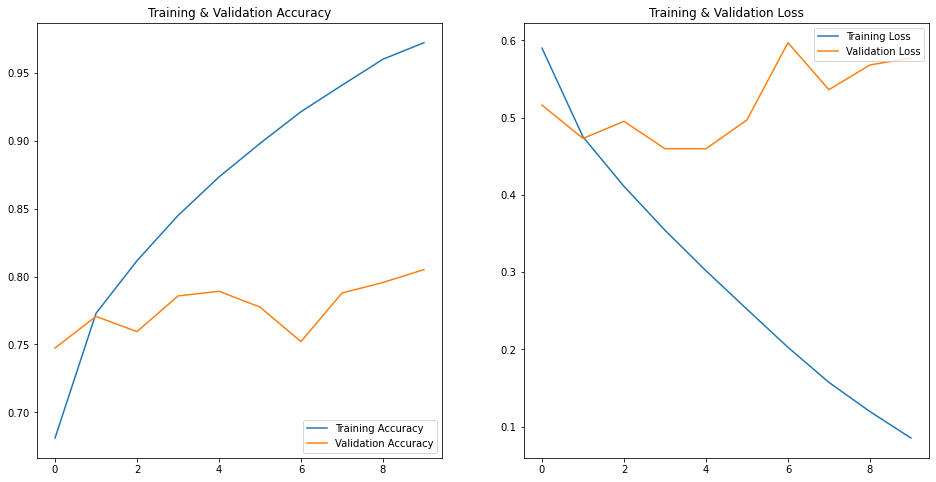

In [20]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(EPOCHS)

plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title("Training & Validation Accuracy")

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label="Training Loss")
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title("Training & Validation Loss")
plt.show()

정확도와 손실값에 대한 두가지 그래프를 그려보았습니다.

두 그래프 모두 훈련 데이터셋에는 좋은 결과값을 보이지만, validation 데이터셋에서는 그렇지 않은 것 같네요.

validation에서 accuracy는 일정 수준 이상 올라가지 않고, loss는 어느 순간에서는 오히려 갑자기 증가합니다. 이는 보통 **과적합(overfitting)** 이라고 하죠.

---

그럼 검증 정확도가 80%정도까지 올라간 우리 모델의 예측 결과를 확인해볼까요? 모델의 예측 결과를 확인하고 싶을 때에는 `model.predict`를 사용합니다.

In [21]:
for image_batch, label_batch in test_batches.take(1):
    images = image_batch
    labels = label_batch
    predictions = model.predict(image_batch)
    pass

predictions

array([[7.5283206e-01, 2.4716793e-01],
       [9.9888533e-01, 1.1146830e-03],
       [9.6674705e-01, 3.3252966e-02],
       [8.2628387e-01, 1.7371619e-01],
       [1.9168669e-01, 8.0831337e-01],
       [1.4338099e-03, 9.9856621e-01],
       [9.9971312e-01, 2.8691045e-04],
       [1.5203586e-01, 8.4796411e-01],
       [9.7448617e-01, 2.5513787e-02],
       [1.7163326e-01, 8.2836670e-01],
       [2.9950853e-02, 9.7004920e-01],
       [4.0503716e-01, 5.9496284e-01],
       [7.7151828e-02, 9.2284822e-01],
       [5.1109165e-02, 9.4889086e-01],
       [1.8686069e-02, 9.8131394e-01],
       [9.8881245e-01, 1.1187596e-02],
       [8.1930810e-01, 1.8069191e-01],
       [5.9574023e-03, 9.9404258e-01],
       [2.9377585e-02, 9.7062242e-01],
       [9.9997866e-01, 2.1353482e-05],
       [6.8242985e-01, 3.1757012e-01],
       [2.0671639e-01, 7.9328364e-01],
       [3.6077961e-01, 6.3922036e-01],
       [1.6631728e-01, 8.3368272e-01],
       [1.6570031e-05, 9.9998343e-01],
       [9.1126788e-01, 8.

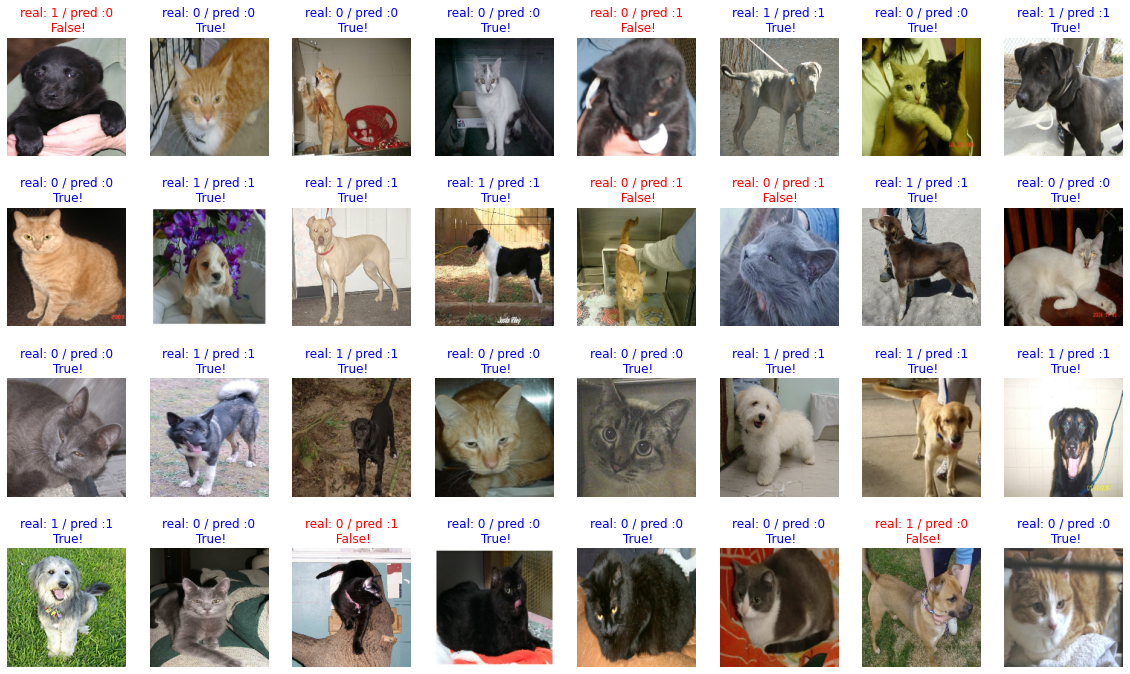

In [22]:
import numpy as np

predictions = np.argmax(predictions, axis=1)

plt.figure(figsize=(20, 12))

for idx, (image, label, prediction) in enumerate(zip(images, labels, predictions)):
    plt.subplot(4, 8, idx+1)
    image = (image + 1) / 2
    plt.imshow(image)
    correct = label == prediction
    title = f'real: {label} / pred :{prediction}\n {correct}!'
    if not correct:
        plt.title(title, fontdict={'color': 'red'})
    else:
        plt.title(title, fontdict={'color': 'blue'})
    plt.axis('off')

`predictions`의 값을 0또는 1로 변환해주고, 한번 이미지로 확인해보았습니다. 제대로 예측하지 못한 이미지들을 보면 약간 그럴 것 같은 이미지들이 그랬죠? 

직접 맞은 예측의 갯수를 세봅시다.

In [23]:
count = 0   # 정답을 맞춘 개수
for image, label, prediction in zip(images, labels, predictions):
  correct = label == prediction
  if correct:
    count = count + 1

print(count / 32 * 100)    # 약 70% 내외

81.25


약 81%정도로 맞추네요. 나쁘지 않은 정확도긴 하지만, 다른 사람들이 만들어놓은 모델을 통해서 더 정확도를 높여볼까요?

## VGG16 모델을 사용해보기

간단한 코드로 VGG 모델을 base_model 변수로 불러와 사용해봅시다.

VGG모델을 가져올 때 3개의 FC레이어는 제외하고 불러오기때문에 `include_top=False` 옵션을 주고 불러옵시다.

In [24]:
IMG_SHAPE = (IMG_SIZE, IMG_SIZE, 3)

base_model = tf.keras.applications.VGG16(
    input_shape = IMG_SHAPE,
    include_top = False,
    weights = 'imagenet')

base_model을 잘 불러온 것 같습니다. 그럼 이 모델을 배치에 넣어볼까요?

In [25]:
feature_batch = base_model(image_batch)
feature_batch.shape

TensorShape([32, 5, 5, 512])

모델의 구조를 한번 확인해봅시다! 앞서 말한대로, 모델의 구조는 `model.summary()`를 통해서 알 수 있습니다.

In [26]:
base_model.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 160, 160, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 160, 160, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 160, 160, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 80, 80, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 80, 80, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 80, 80, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 40, 40, 128)       0     

와 훨씬 복잡해보이는 구조네요!

그럼 이제 우리는 이 모델이 추출한 특징 벡터로부터 분류를 할 수 있는 classifier를 구성해야합니다.

먼저 한가지 생각할 것이 있습니다. VGG16모델이 출력한 벡터의 shape가 무엇인지 살펴봅시다.

In [27]:
feature_batch.shape

TensorShape([32, 5, 5, 512])

네! 바로 (5, 5, 512)크기의 벡터가 32개 있는 (32, 5, 5, 512)입니다.

그런데 classifier를 구성하려면 우리는 Fully Connected Layer로 구성해야합니다. 이러한 구조로 인해 벡터는 반드시 1차원이 되어야 합니다.

하지만 VGG16이 출력하는 벡터는 (5, 5, 512)로 3차원 구조로 가지고 있습니다. 따라서 우리는 classifier를 구성하기 전에 이 3차원 벡터를 1차원 벡터로 변환하는 작업을 거쳐야합니다.

이럴때 사용한 방법이 위에서는 *Flatten*이었죠. 그런데 이번에는 조금 다른 방식을 생각해볼까요?

바로 **Global Average Pooling**입니다. 

![img](https://aiffelstaticprd.blob.core.windows.net/media/images/e-4-3-3.max-800x600.png)

Global Average Pooling은 위와 같이 3차원 벡터가 있을 때 겹겹이 쌓여있는 2차원 배열을 평균취한 후 하나의 값으로 축소시키는 기법입니다. 

위 그림에서는 4x4행렬에 있는 16개 숫자의 평균값을 구했어요. 이렇게 ***평균값을 활용해 벡터의 차원을 줄이는 방법을 Global Average Pooling***이라고 합니다.


그러면 바로 Global Average Pooling 계층을 만들어봅시다!

In [28]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()

이 `global_average_layer`에 위에서 VGG16이 출력했던 `feature_batch`를 입력하면 어떻게 될까요?

In [29]:
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(32, 512)


네 저희가 원하는 값이 제대로 나왔네요! 

그러면 마지막으로 Dense 레이어들을 붙여주면 우리의 classifier가 완성됩니다.

In [30]:
dense_layer = Dense(512, activation='relu')
prediction_layer = Dense(2, activation = 'softmax')

prediction_batch = prediction_layer(dense_layer(feature_batch_average))
print(prediction_batch.shape)

(32, 2)


이제 모델을 만들 준비는 모두 끝났습니다.

이제 우리의 데이터들은 처음 이미지에서 특징을 추출해줄 VGG16 `base_model`에 입력되어 특징이 추출된 다음, 그 특징 벡터는 `global_average_layer`를 거쳐 마지막에 `prediction_layer`까지 통과하며 강아지인지 고양이인지 예측할 것입니다.

여기서 VGG16에 해당하는 base_model은 학습시키지 않을 예정이니 학습 여부를 결정하는 `trainable` 변수를 `False`로 지정해줍시다.

In [31]:
base_model.trainable = False

그럼 진짜 최종 모델을 만들어봅시다!

In [32]:
model = Sequential([
    base_model,
    global_average_layer,
    dense_layer,
    prediction_layer
])

우리가 만든 모델의 구조를 한번 확인해볼까요?

In [33]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 5, 5, 512)         14714688  
_________________________________________________________________
global_average_pooling2d (Gl (None, 512)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 512)               262656    
_________________________________________________________________
dense_3 (Dense)              (None, 2)                 1026      
Total params: 14,978,370
Trainable params: 263,682
Non-trainable params: 14,714,688
_________________________________________________________________


간단하게 나왔네요! 물론 vgg16에서 복잡한 구조가 있었죠?

그럼 만든 모델을 바탕으로 학습시켜봅시다.


## 모델 학습하기

모델 학습 과정은 위와 같습니다.

`optimizer`, `loss`, `metrics`를 준비해서 모델을 compile하기만 하면 됩니다.

In [34]:
base_learning_rate = 0.0001
model.compile(
    optimizer = tf.keras.optimizers.RMSprop(lr = base_learning_rate),
    loss = tf.keras.losses.sparse_categorical_crossentropy,
    metrics=['accuracy']
)

그럼 이제 모델을 학습시켜봅시다!

In [35]:
EPOCHS = 5

history = model.fit(train_batches,
                   epochs = EPOCHS,
                   validation_data = validation_batches)

Epoch 1/5
582/582 [==============================] - 100s 173ms/step - loss: 0.2527 - accuracy: 0.9082 - val_loss: 0.1751 - val_accuracy: 0.9353
Epoch 2/5
582/582 [==============================] - 46s 80ms/step - loss: 0.1580 - accuracy: 0.9366 - val_loss: 0.1466 - val_accuracy: 0.9448
Epoch 3/5
582/582 [==============================] - 47s 80ms/step - loss: 0.1448 - accuracy: 0.9403 - val_loss: 0.1408 - val_accuracy: 0.9457
Epoch 4/5
582/582 [==============================] - 47s 80ms/step - loss: 0.1365 - accuracy: 0.9433 - val_loss: 0.1396 - val_accuracy: 0.9427
Epoch 5/5
582/582 [==============================] - 46s 79ms/step - loss: 0.1325 - accuracy: 0.9453 - val_loss: 0.1323 - val_accuracy: 0.9431


validation set에서 정확도가 94% 가까이 나타나고 있습니다!

그래프로 학습 과정을 한번 확인해봅시다.

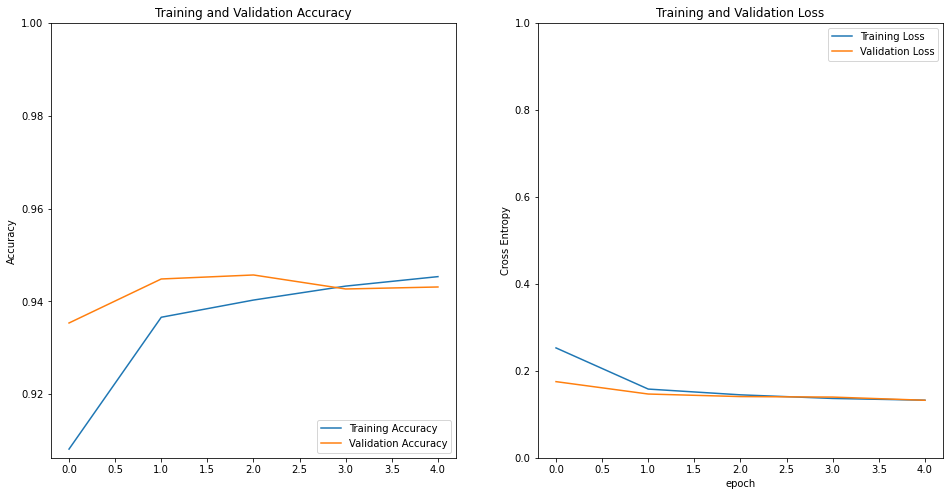

In [36]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

처음에 만들었던 모델과는 다르게 시작부터 정확도가 75%가 넘고 꾸준히 올라갈 뿐더러, loss도 매우 안정적으로 학습됩니다.

위에서 했던 것 같이 32개의 test sample에 대한 예측 결과를 눈으로 확인해봅시다. 샘플을 test batches에서 가져와 예측 결과를 만들어봅시다.

In [37]:
for image_batch, label_batch in test_batches.take(1):
    images = image_batch
    labels = label_batch
    predictions = model.predict(image_batch)
    pass

predictions

array([[2.9629160e-02, 9.7037077e-01],
       [9.9975151e-01, 2.4847564e-04],
       [9.0375811e-01, 9.6241899e-02],
       [9.9521697e-01, 4.7830287e-03],
       [9.6546090e-01, 3.4539089e-02],
       [5.7973233e-05, 9.9994206e-01],
       [9.9254507e-01, 7.4549611e-03],
       [2.8681112e-07, 9.9999976e-01],
       [9.9855155e-01, 1.4484740e-03],
       [5.4664342e-06, 9.9999452e-01],
       [2.1482243e-05, 9.9997854e-01],
       [1.4419489e-03, 9.9855810e-01],
       [5.3550380e-01, 4.6449617e-01],
       [5.2893782e-01, 4.7106221e-01],
       [1.2482156e-04, 9.9987519e-01],
       [9.9526924e-01, 4.7307778e-03],
       [9.9877173e-01, 1.2283081e-03],
       [4.7693881e-03, 9.9523062e-01],
       [1.5206454e-02, 9.8479348e-01],
       [9.9916649e-01, 8.3359005e-04],
       [9.9762648e-01, 2.3734854e-03],
       [1.5117407e-04, 9.9984884e-01],
       [1.7649692e-05, 9.9998236e-01],
       [3.4565541e-03, 9.9654347e-01],
       [2.0028519e-08, 1.0000000e+00],
       [9.7219288e-01, 2.

이번에도 prediction 값들을 실제 추론한 라벨로 변환해봅시다.

In [38]:
predictions = np.argmax(predictions, axis=1)
predictions

array([1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1,
       1, 1, 1, 0, 0, 0, 0, 0, 1, 0])

바로 한번 확인해볼까요?

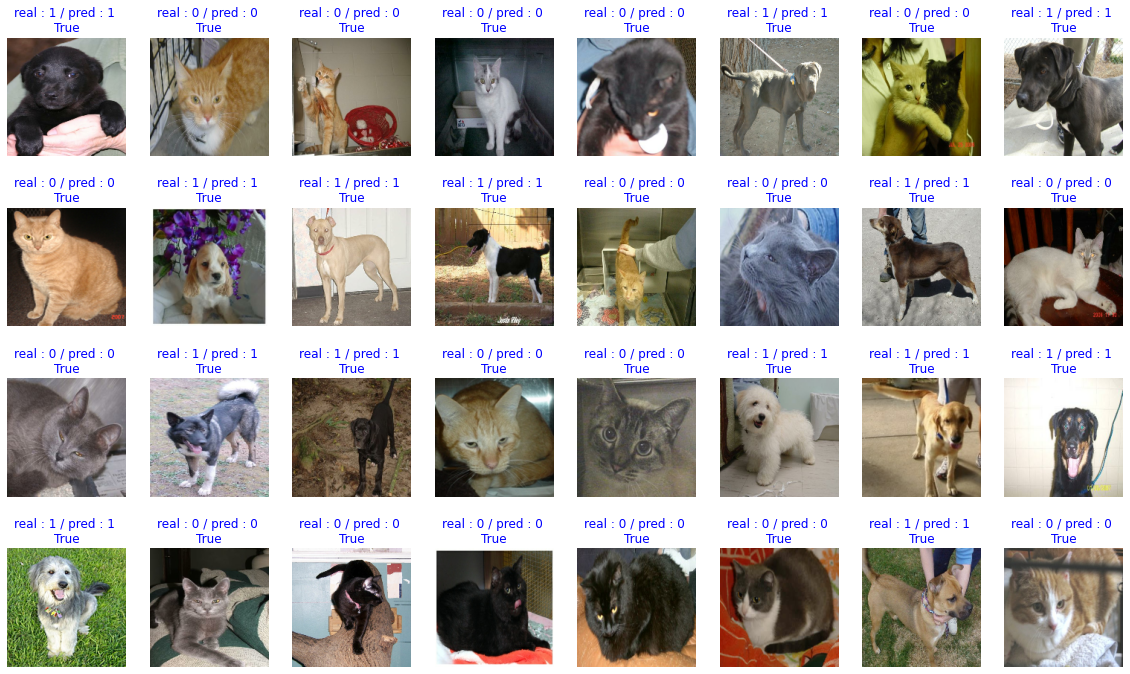

In [39]:
plt.figure(figsize=(20, 12))

for idx, (image, label, prediction) in enumerate(zip(images, labels, predictions)):
    plt.subplot(4, 8, idx+1)
    image = (image+1)/2
    plt.imshow(image)
    correct = label == prediction
    title = "real : {} / pred : {} \n{}".format(label, prediction, correct)
    if not correct:
        plt.title(title, fontdict={'color' : 'red'})
    else:
        plt.title(title, fontdict={'color' : 'blue'})
    plt.axis('off')

와~ 잘 맞네요!! 

Transfer Learning의 위력을 실감할 수 있었습니다. 이미지를 분류할 때 직접 모델을 만들기보다는 똑똑한 모델을 가져와서 사용하는 것이 좋을 것 같네요!

## 모델 저장하기

수많은 시간과 노력을 들여 모델을 만들었어요!

매번 할때마다 계속 모델을 학습시킬수는 없으니, 모델을 저장하비다!

아래와 같이 `./checkpoint/checkpoint`라는 경로로 저장하게되면 현재 위치에 있는 `checkpoint`라는 폴더 내에 `checkpoint`라는 파일명으로 저장됩니다.

아래와 같이 터미널을 열어 해당 폴더를 만들어주고 모델을 저장해줍시다!

In [41]:
!mkdir -p cat_vs_dog
!mkdir -p cat_vs_dog/checkpoint
!mkdir -p cat_vs_dog/images

In [47]:
import os

checkpoint_dir =os.path.dirname(os.path.abspath('__file__'))
checkpoint_dir += r'\cat_vs_dog\checkpoint'
checkpoint_file_path = os.path.join(checkpoint_dir, 'checkpoint')

if not os.path.exists('checkpoint_dir'):
    os.mkdir('checkpoint_dir')

model.save_weights(checkpoint_file_path)

if os.path.exists(checkpoint_file_path):
    print("checkpoint 파일 생성 Done!")

checkpoint 파일 생성 Done!


## 고양이일까? 강아지일까? 고양이상일까 강아지상일까?

그럼 이제 고양이와 강아지 이미지를 넣어볼까요?